<a href="https://colab.research.google.com/github/emil565a/NLP/blob/main/NLP_Project_week_38Versionxxx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install sklearn
!pip3 install nltk
!pip3 install transformers
!pip install transformers datasets evaluate
!pip install transformers[torch]
!pip install accelerate -U
!pip3 install transformers[torch]
!pip3 install accelerate -U
!pip3 install gensim
!pip3 install sentence-transformers
!import nltk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from datasets import load_dataset
import pandas as pd
import nltk
import string
import re

import tensorflow as tf

import transformers
from transformers import AutoTokenizer
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import AutoModelForQuestionAnswering
from transformers import DefaultDataCollator
from transformers import TFTrainer #Used for training model
from transformers import TFTrainingArguments #Used fo training arguments
from transformers import BertTokenizer, squad_convert_examples_to_features, SquadV2Processor
from transformers.data.processors.squad import SquadExample
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

#import gensim
from gensim import corpora
from gensim import models
from gensim import similarities
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import matutils

In [3]:
nltk.download('punkt')
dataset = load_dataset("copenlu/answerable_tydiqa")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/116067 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13325 [00:00<?, ? examples/s]

In [4]:
# Also load dataset as pandas.DataFrame, in case we need it later
train_pd = pd.DataFrame(data=dataset["train"])
validation_pd = pd.DataFrame(data=dataset["validation"])

In [5]:
arabic_train = train_pd[train_pd['language'] == 'arabic']
bengali_train = train_pd[train_pd['language'] == 'bengali']
indo_train = train_pd[train_pd['language'] == 'indonesian']

arabic_validation = validation_pd[validation_pd['language'] == 'arabic']
bengali_validation = validation_pd[validation_pd['language'] == 'bengali']
indo_validation = validation_pd[validation_pd['language'] == 'indonesian']

In [6]:
#print columns
print(arabic_train.columns)

Index(['question_text', 'document_title', 'language', 'annotations',
       'document_plaintext', 'document_url'],
      dtype='object')


In [7]:
def tokenizerOld(text):
  #Tokenize the text and translate
  tokens = [word.lower() for word in nltk.word_tokenize(text)]
  return tokens

#New that utilize transformer.AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
def tokenize_function(text):
    return tokenizer(text, padding="max_length", truncation=True)

class entry:
    def __init__(self, question_text, document_title, language, annotations, document_plaintext, document_url):
        self.question_text = question_text
        self.document_title = document_title
        self.language = language
        self.annotations = annotations
        self.answerable = annotations.get("answer_start", [-1]) != [-1]
        self.document_plaintext = document_plaintext
        self.document_url = document_url
        self.question_tokenized = tokenizerOld(self.question_text)
        self.document_tokenized = tokenizerOld(self.document_plaintext)

        #To use with the transformer library
        self.answers = {'answer_start': annotations['answer_start'], 'text': annotations['answer_text']}
        self.context = document_plaintext
        self.id = document_url
        self.question = question_text
        self.title = document_title


    def __str__(self):
        return f"Question: {self.question_text}\n" \
               f"Document Title: {self.document_title}\n" \
               f"Language: {self.language}\n" \
               f"Annotations: {self.annotations}\n" \
               f"Document Plaintext: {self.document_plaintext}\n" \
               f"Document URL: {self.document_url}\n" \
               f"Answerable: {self.answerable}"\
               f"Question Tokenized: {self.question_tokenized}\n" \
               f"Document Tokenized: {self.document_tokenized}"

arabic_train_entries = []
for index,row in arabic_train.iterrows():
    arabic_train_entries.append(entry(row['question_text'], row['document_title'], row['language'], row['annotations'], row['document_plaintext'], row['document_url']))

arabic_validation_entries = []
for index,row in arabic_validation.iterrows():
    arabic_validation_entries.append(entry(row['question_text'], row['document_title'], row['language'], row['annotations'], row['document_plaintext'], row['document_url']))


bengali_train_entries = []
for index,row in bengali_train.iterrows():
    bengali_train_entries.append(entry(row['question_text'], row['document_title'], row['language'], row['annotations'], row['document_plaintext'], row['document_url']))

bengali_validation_entries = []
for index,row in bengali_validation.iterrows():
    bengali_validation_entries.append(entry(row['question_text'], row['document_title'], row['language'], row['annotations'], row['document_plaintext'], row['document_url']))

indo_train_entries = []
for index,row in indo_train.iterrows():
    indo_train_entries.append(entry(row['question_text'], row['document_title'], row['language'], row['annotations'], row['document_plaintext'], row['document_url']))
indo_validation_entries = []
for index,row in indo_validation.iterrows():
    indo_validation_entries.append(entry(row['question_text'], row['document_title'], row['language'], row['annotations'], row['document_plaintext'], row['document_url']))



# Simple classifier (Well in terms of lines of code)

In [8]:
pipelineModel = pipeline("question-answering", model="timpal0l/mdeberta-v3-base-squad2")


# Emils Supervised Classifier

### Preproccesing


In [9]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question_text"]]
    inputs = tokenizer(
        questions,
        examples["document_plaintext"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["annotations"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["answer_text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

### tokenize the data

In [24]:
#tokenizerArabic  = AutoTokenizer.from_pretrained("timpal0l/mdeberta-v3-base-squad2")

#https://huggingface.co/arabi-elidrisi/ArabicDistilBERT_QA
arabic_dataset = dataset.filter(lambda example: example['language'] == 'arabic' and example['annotations']['answer_start'] != [-1])
arabic_tokenizer = AutoTokenizer.from_pretrained("arabi-elidrisi/ArabicDistilBERT_QA")
arabic_tokenized_squad = arabic_dataset.map(preprocess_function, batched=True, remove_columns=arabic_dataset["train"].column_names)
arabic_model = AutoModelForQuestionAnswering.from_pretrained("arabi-elidrisi/ArabicDistilBERT_QA")

#https://huggingface.co/sagorsarker/mbert-bengali-tydiqa-qa
bengali_dataset = dataset.filter(lambda example: example['language'] == 'bengali' and example['annotations']['answer_start'] != [-1])
bengali_tokenizer = AutoTokenizer.from_pretrained("sagorsarker/mbert-bengali-tydiqa-qa")
bengali_tokenized_squad = bengali_dataset.map(preprocess_function, batched=True, remove_columns=bengali_dataset["train"].column_names)
bengali_model = AutoModelForQuestionAnswering.from_pretrained("sagorsarker/mbert-bengali-tydiqa-qa")

#https://huggingface.co/Rifky/Indobert-QA
indo_dataset = dataset.filter(lambda example: example['language'] == 'indonesian' and example['annotations']['answer_start'] != [-1])
indo_tokenizer = AutoTokenizer.from_pretrained("Rifky/Indobert-QA")
indo_tokenized_squad = indo_dataset.map(preprocess_function, batched=True, remove_columns=indo_dataset["train"].column_names)
indo_model = AutoModelForQuestionAnswering.from_pretrained("Rifky/Indobert-QA")

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

Map:   0%|          | 0/14805 [00:00<?, ? examples/s]

Map:   0%|          | 0/951 [00:00<?, ? examples/s]

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

Map:   0%|          | 0/2390 [00:00<?, ? examples/s]

Map:   0%|          | 0/112 [00:00<?, ? examples/s]

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

Map:   0%|          | 0/5702 [00:00<?, ? examples/s]

Map:   0%|          | 0/597 [00:00<?, ? examples/s]

In [11]:
data_collator = DefaultDataCollator()

### Training the model

In [25]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=128e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.000001,
)

arabic_trainer = Trainer(
    model=arabic_model,
    args=training_args,
    train_dataset= arabic_tokenized_squad["train"],
    eval_dataset= arabic_tokenized_squad["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

arabic_trainer.train()


Epoch,Training Loss,Validation Loss
1,5.969500,5.950643


TrainOutput(global_step=14805, training_loss=6.009528888572273, metrics={'train_runtime': 2128.5174, 'train_samples_per_second': 6.956, 'train_steps_per_second': 6.956, 'total_flos': 2578137405258240.0, 'train_loss': 6.009528888572273, 'epoch': 1.0})

In [27]:
arabic_model_fine_tuned = AutoModelForQuestionAnswering.from_pretrained("./results/checkpoint-14500")


In [ ]:
def findOptimalAccuracyScore(model, validationData):
  accuracy_scores = []
  for i in range(1, 100):
    y_true = [entry.answerable for entry in validationData]
    y_pred = []

    for entry in validationData:
      answerable = entry.answerable
      question = entry.question_text
      document = entry.document_plaintext
      modelPred = model(question, document)
      if modelPred['score'] > i/100:
        y_pred.append(True)
      else:
        y_pred.append(False)
    accuracy_scores.append(accuracy_score(y_true, y_pred))
  return max(accuracy_scores), accuracy_scores

# Model 2: Encoding via SentenceTransformer & SGD Classifier

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Get encoding model from SentenceTransformer package
# Derived from here: https://huggingface.co/intfloat/multilingual-e5-base
model = SentenceTransformer("intfloat/multilingual-e5-base")

def train_SGD_classifier(training_data, validation_data, language):
    # Encode documents and questions to create inputs of size=768
    train_document_e = model.encode([x for x in training_data["document_plaintext"]])
    train_question_e = model.encode([x for x in training_data["question_text"]])
    valid_document_e = model.encode([x for x in validation_data["document_plaintext"]])
    valid_question_e = model.encode([x for x in validation_data["question_text"]])

    # Collect labels (true outputs) for each pair
    train_labels = [1 if x["answer_start"] != [-1] else 0 for x in training_data["annotations"]]
    valid_labels = [1 if x["answer_start"] != [-1] else 0 for x in validation_data["annotations"]]

    # Concatenate "document encoding" and "question encoding" to create combined inputs of size=1536
    train_combined_e = [np.concatenate((x[0], x[1]), axis=0) for x in zip(train_document_e, train_question_e)]
    valid_combined_e = [np.concatenate((x[0], x[1]), axis=0) for x in zip(valid_document_e, valid_question_e)]

    # Train SGD Classifier instance
    classifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=100)
    classifier.fit(train_combined_e, train_labels)

    # Determine classifier accuracy based on true/predicted scores
    outputs = classifier.predict(valid_combined_e)
    print("Accuracy score (" + language + "): " + str(accuracy_score(valid_labels, outputs)))

# Test SGD Classifier for each input language
for train, valid, lang in [(arabic_train, arabic_validation, "arabic"),
                           (bengali_train, bengali_validation, "bengali"),
                           (indo_train, indo_validation, "indonesian")]:
    train_SGD_classifier(train, valid, lang)

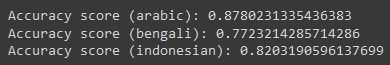

# Model 3: Encoding via TFIDF & SGD Classifier

In [ ]:
import numpy as np
from numpy.linalg import norm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

def train_TFIDF_SGD_classifier(train, validation, language):
    # Combine all data into single input
    train_combined = np.concatenate((train["document_plaintext"], train["question_text"]), axis=0)
    valid_combined = np.concatenate((validation["document_plaintext"], validation["question_text"]), axis=0)
    combined = np.concatenate((train_combined, valid_combined), axis=0)

    # Determine TFIDF Scores via TfidfVectorizer class from scikit
    vectorizer = TfidfVectorizer(max_features=100000) # Don't increase this, it will crash RAM! O_o
    denseTF_IDF_vectors = vectorizer.fit_transform(combined).toarray()

    # Separate output train/validation and document/question data
    tf_train_combined = denseTF_IDF_vectors[:train_combined.shape[0]]
    tf_valid_combined = denseTF_IDF_vectors[train_combined.shape[0]:]
    tf_train_doc = tf_train_combined[:len(tf_train_combined)//2]
    tf_train_que = tf_train_combined[len(tf_train_combined)//2:]
    tf_valid_doc = tf_valid_combined[:len(tf_valid_combined)//2]
    tf_valid_que = tf_valid_combined[len(tf_valid_combined)//2:]

    # Manually determine cosine similarities between document/question for each dataset
    X_train = [[np.dot(A,B)/(norm(A)*norm(B))] if (norm(A) != 0 and norm(B) != 0) else [0.0]
                for A, B in zip(tf_train_doc, tf_train_que)]
    X_test = [[np.dot(A,B)/(norm(A)*norm(B))] if (norm(A) != 0 and norm(B) != 0) else [0.0]
            for A, B in zip(tf_valid_doc, tf_valid_que)]

    # Get true labels from dataset
    y_train = [1 if x["answer_start"] != [-1] else 0 for x in train["annotations"]]
    y_test = [1 if x["answer_start"] != [-1] else 0 for x in validation["annotations"]]

    # Train SGD Classifier instance
    classifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=100)
    classifier.fit(X_train, y_train)

    # Determine classifier accuracy based on true/predicted scores
    outputs = classifier.predict(X_test)
    print("Accuracy score (" + language + "): " + str(accuracy_score(y_test, outputs)))

for train, valid, lang in [(arabic_train, arabic_validation, "arabic"),
                           (bengali_train, bengali_validation, "bengali"),
                           (indo_train, indo_validation, "indonesian")]:
    train_TFIDF_SGD_classifier(train, valid, lang)

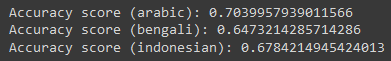